In [1]:
from bs4 import BeautifulSoup
import requests
import time, os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

## Navigating to our page

In [ ]:
chromedriver= "/Applications/chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver

In [ ]:
#instantiate the driver
driver = webdriver.Chrome(chromedriver)

In [ ]:
#head to the car finder URL
url = "https://www.kbb.com/car-finder/270/?years=2010-2022"
driver.get(url)

In [ ]:
#change lower year range to 2010
year_element = driver.find_element_by_xpath('//select[@class="css-16ihsqz-StyledSelect e1lpma6w4"]')
year = driver.find_element_by_xpath('//option[@value="2010"]')
year.click()
time.sleep(1)

In [ ]:
#define functions that will handle our errors and scrape
def get_name_year(soup):
    car_title = soup.find('h1').text
    
    if not car_title:
        return None, None
        
    car_name = car_title[5:]
    car_year = car_title[0:4]

    if not car_name:
        car_name=None
    if not car_year:
        car_year=None
    return car_name, car_year

In [ ]:
from selenium.common.exceptions import NoSuchElementException

def get_ratings(soup):
    try:
        expert_rating = float(soup.find_all(class_="css-1a75k9o")[0].text)
    except IndexError:
        expert_rating=None
        
    try:
        consumer_rating = float(driver.find_elements_by_xpath('//div[@class="css-1ohwf54"]')[0].text)
    except IndexError:
        consumer_rating=None
    try:
        safety = driver.find_element_by_xpath('//div[contains(@id, "safety")]')
    except NoSuchElementException:
        safety=None
    try:
        found_crash = safety.find_element_by_xpath('.//div[@class="css-1ohwf54"]')
    except (NoSuchElementException, AttributeError):
        found_crash = None
    
    if not found_crash:
        crash_rating=None
    else:
        crash_rating = float(found_crash.text)
    
        
    return expert_rating, consumer_rating, crash_rating


In [ ]:
def get_specs(soup):
    spec_data_list = []
    
    #get the fuel type
    try:
        fuel_type = soup.find_all(class_="css-bl5ixv-StyledResponsive-StyledDataPoint-StyledDataPoint-StyledDataPoint e1obsm7a1",
             text = "Fuel Type")[0].findNext().text
    except IndexError:
        fuel_type=None
    spec_data_list.append(fuel_type)
    
    #get all the important specs from a table on the page
    list_of_specs = ["Fuel Capacity","Front Leg Room", "Max Seating Capacity","Minimum Ground Clearance","Overall Length",
                 "Towing Capacity, Maximum","Trunk or Cargo Capacity", "Turning Diameter","Payload Capacity",
                 "Width with mirrors", "Drivetrain","Transmission Type", "Number of Doors", "Horsepower","Combined"]
    for spec in list_of_specs:
        spec_next = soup.find(text=spec)
        if spec == "Combined":
            try:
                combined = soup.find('div', class_="data-points css-1rjvdv4 erywcq02").find(class_="css-1eqyldx-StyledResponsive-StyledDataPoint-StyledDataPoint-StyledDataPoint e1obsm7a1").text
                spec_data_list.append(combined)
            except AttributeError:
                spec_data_list.append(None)
        else:
            try:
                detail = spec_next.findNext().text
                spec_data_list.append(detail)
            except AttributeError:
                spec_data_list.append(None)
        
    #count up the extra amenities in each category
    categories = ["Technology","Entertainment","Seating","Interior","Security"]
    
    for category in categories:
        section = soup.find(class_="css-1qgxdnp-StyledHeading3 e1fzhy9e2", text=f"{category}")
        if not section:
            specs=0
        else: 
            specs = soup.find(class_="css-1qgxdnp-StyledHeading3 e1fzhy9e2", text=f"{category}").findNext().find_all('li')
            if not specs:
                spec_data_list.append(None)
            else:
                spec_data_list.append(len(specs))
    try:           
        comf = len(soup.find('div',text="Comfort & Convenience").findNext().findNext().find_all('li'))
    except AttributeError:
        try:
            comf = len(soup.find('div', text="Comfort & Convenience").findNext().find_all('ul'))
        except AttributeError:
            comf=None
    spec_data_list.append(comf)
    
    return spec_data_list
            
    

In [ ]:
#create our data dict 
car_dict = {}

In [ ]:
# find out how many cars are on the page
# for each car on the page, click on that car, 
# do something, and then come back out
num_pages = int(driver.find_elements_by_xpath('//button[@class="css-1xv7t27-NumberButton-buttonStyles-activeState-focusState-activeButtonStyles eem3vrg1"]')[-1].text)


for p in range(1,num_pages+1):

    for i in range(len(driver.find_elements_by_xpath('//div[contains(@id, "vehicle_card")]'))):

        element = driver.find_elements_by_xpath('//div[contains(@id, "vehicle_card")]')[i]
        #find the starting price and add it to our data
        data_list=[]
        start_price = element.find_element_by_xpath('.//div[@class="css-1hknbws-StyledStatic-StyledDataPoint e1obsm7a0"]').text
        data_list.append(start_price)

        #click into the car's full detail page
        see_deets_button = element.find_element_by_xpath('.//a[@class="css-1micxwe-transitionRules-default"]')
        see_deets_button.click()
        time.sleep(1)
        
        try:
            driver.find_element_by_xpath('//div[@id="fsrInvite"]')
            nothanks= driver.find_element_by_xpath('//button[@title="No thanks"]')
            nothanks.click()
        except NoSuchElementException:
            pass

        #scrape all needed data from detail page & add to our list
        soup = BeautifulSoup(driver.page_source, 'html.parser')

        try:
            name, year = get_name_year(soup)
            data_list.append(year)
        except AttributeError:
            continue

        expert_rating, consumer_rating, crash_rating = get_ratings(soup)
        data_list.append(expert_rating)
        data_list.append(consumer_rating)
        data_list.append(crash_rating)

        for spec in get_specs(soup):
            data_list.append(spec)

        car_dict[name] = data_list 

        #go back out to the main search page
        driver.execute_script("window.history.go(-1)")
        time.sleep(1)
        
        try:
            driver.find_element_by_xpath('//div[@id="fsrInvite"]')
            nothanks= driver.find_element_by_xpath('//button[@title="No thanks"]')
            nothanks.click()
        except NoSuchElementException:
            pass
    
    
    page_num = int(driver.find_element_by_xpath('//button[@class="css-eijd2m-SelectedButton-buttonStyles-activeState-focusState-activeButtonStyles eem3vrg0"]').text)
    df = pd.DataFrame.from_dict(car_dict, orient="index")
    df.to_csv(f'dataframe2_{page_num}')
    
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    next_button = driver.find_element_by_xpath('//button[@type="right"]')
    next_button.click()
    time.sleep(1)
    
    



## Combine into DataFrame

In [2]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split

%matplotlib inline


#add all the saved dfs together (there will be duplicates)

cols=['name','start_price','year','expert_rating',
                               'consumer_rating','crash_rating', 'fuel_type',
                               "fuel_capacity","front_leg_room", "max_seating_capacity",
                                "minimum_ground_clearance","overall_length","towing_capacity",
                                "trunk_capacity", "turning_diameter","payload_capacity",
                                 "width_with_,mirrors", "drivetrain","transmission_type", 
                                "number_of_doors", "horsepower","combined","tech_specs",
                                "entertainment_specs","seating_specs","interior_specs",
                                "security_specs","comfort_specs"]

full_df = pd.DataFrame(columns=cols)

for i in range(300):
    try:
        next_dataframe = pd.read_csv(f'dataframe_{i}', names=cols)
        full_df = pd.concat([full_df, next_dataframe])
    except FileNotFoundError:
        pass 
    
    try:
        next_dataframe2 = pd.read_csv(f'dataframe2_{i}', names=cols)
        full_df = pd.concat([full_df, next_dataframe])
    except FileNotFoundError:
        continue
    
full_df = full_df.drop_duplicates()

## Data Cleaning

In [3]:
#real basic stuff, can't learn anything
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4698 entries, 0 to 8
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      4695 non-null   object 
 1   start_price               4698 non-null   object 
 2   year                      4698 non-null   object 
 3   expert_rating             4565 non-null   float64
 4   consumer_rating           4520 non-null   float64
 5   crash_rating              1691 non-null   float64
 6   fuel_type                 4608 non-null   object 
 7   fuel_capacity             4429 non-null   object 
 8   front_leg_room            4053 non-null   object 
 9   max_seating_capacity      4612 non-null   object 
 10  minimum_ground_clearance  2761 non-null   object 
 11  overall_length            4572 non-null   object 
 12  towing_capacity           3803 non-null   object 
 13  trunk_capacity            3630 non-null   object 
 14  turning_dia

In [4]:
na_list = ['tech_specs', 'entertainment_specs', 'seating_specs', 'interior_specs', 'security_specs', 'comfort_specs']
for col in na_list:
    full_df[f'{col}'].fillna(0, inplace=True)

In [5]:
full_df.dropna(axis=0,subset=['name', 'consumer_rating'], inplace=True)
full_df["used"] = np.where(full_df["year"]=="Used", 1,0)
df = full_df.copy()
df.year[df.year == "Used"] = df["name"].str[:4]
df.name[df.used == 1] = df["name"].str[5:]
df["brand"] = df["name"].str.split(" ").str[0]

In [6]:
pd.options.display.max_columns=100
df=df.rename({"fuel_capacity":"fuel_capacity_gals", "front_leg_room":"front_leg_room_in", 
          "minimum_ground_clearance":"ground_clearance_in", "overall_length":"length_in",
          "towing_capacity":"towing_capacity_lb","trunk_capacity":"trunk_capacity_ft3",
          "turning_diameter":"turning_diameter_ft","payload_capacity":"payload_capacity_lb",
          "width_with_,mirrors":"width_in","combined":"combined_MPG", "horsepower":"peak_horsepower"}, axis=1)

df.max_seating_capacity = df.max_seating_capacity.astype(float)
df.start_price = df.start_price.str.replace("$","").str.replace(",","").astype(float)
df.towing_capacity_lb = df.towing_capacity_lb.fillna(0)
df.towing_capacity_lb[df.towing_capacity_lb== "Not Recommended"] = 0

def remove_units(row):
    if "inches" in str(row):
        return float(row[:-7])
    elif "gallons" in str(row):
        return float(row[:-8])
    elif "MPG" in str(row):
        return float(row[:3])
    elif "cubic feet" in str(row):
        return float(row[:-11])
    elif "feet" in str(row):
        return float(row[:-5])
    elif "pounds" in str(row):
        return float(row[:-7])
    elif "doors" in str(row):
        return float(row[:-6])
    else:
        return row
        
for col in ["fuel_capacity_gals","front_leg_room_in", "ground_clearance_in","length_in", "towing_capacity_lb",
           "trunk_capacity_ft3", "turning_diameter_ft","payload_capacity_lb",
            "width_in","combined_MPG", "number_of_doors"]:

    df[col] = df[col].apply(remove_units)
    

In [7]:
df = df.reset_index()
df[df.expert_rating.isnull()]
#drop a row with mostly nulls
df=df.drop(index=403)
df=df.drop(['index'], axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4516 entries, 0 to 4516
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  4516 non-null   object 
 1   start_price           4516 non-null   float64
 2   year                  4516 non-null   object 
 3   expert_rating         4516 non-null   float64
 4   consumer_rating       4516 non-null   float64
 5   crash_rating          1687 non-null   float64
 6   fuel_type             4442 non-null   object 
 7   fuel_capacity_gals    4275 non-null   float64
 8   front_leg_room_in     3964 non-null   float64
 9   max_seating_capacity  4442 non-null   float64
 10  ground_clearance_in   2719 non-null   float64
 11  length_in             4410 non-null   float64
 12  towing_capacity_lb    4516 non-null   float64
 13  trunk_capacity_ft3    3506 non-null   float64
 14  turning_diameter_ft   3706 non-null   float64
 15  payload_capacity_lb  

In [9]:
def fix_RPM(row):
    if "0 @ 400 RPM" in str(row):
        return 0.0
    elif "Horsepower-Combined" in str(row):
        return float(row[-14:-11])
    elif "RPM" in str(row):
        return float(row[:-11])
    elif "hp" in str(row).lower():
        return float(row[:-2])
    elif "V6, 3.5 LiterEngine" in str(row):
        return None
    else:
        return float(row)
    
df.peak_horsepower = df.peak_horsepower.apply(fix_RPM)
df.peak_horsepower = df.peak_horsepower.astype(float)

In [10]:
df=df.dropna(axis=0, thresh=21)

In [11]:
df.brand.value_counts()

Ford             356
Chevrolet        343
Mercedes-Benz    323
Toyota           262
Nissan           254
GMC              224
Audi             217
BMW              201
Hyundai          157
Kia              133
Ram              133
Honda            131
Volkswagen       124
Lexus            106
Cadillac          88
MAZDA             84
Subaru            80
Volvo             79
Dodge             79
Acura             76
Porsche           70
Jeep              70
INFINITI          69
Lincoln           68
MINI              64
Buick             63
Land              63
Mitsubishi        60
Jaguar            47
FIAT              45
Ferrari           39
Chrysler          39
Maserati          31
Aston             31
Rolls-Royce       28
Scion             27
Lamborghini       24
Tesla             23
smart             19
Bentley           19
McLaren           17
Suzuki            17
Alfa              16
Genesis           15
Lotus             11
Mercury            7
Maybach            6
Saab         

In [12]:
luxury_brands = ['Jaguar', 'McLaren','Ferrari', 'Bentley', 'Alfa', 'Genesis', 'Porsche',
                'Rolls-Royce', 'Aston', 'Audi', 'BMW', 'Lotus', 'Lamborghini', 'Maserati']

luxury_df = df[df.brand.isin(luxury_brands)]

gas_df = df[(df.fuel_type !="Electric") & (df.fuel_type !="Hydrogen") & 
            (~df.name.str.contains("Cargo")) & (~df.name.str.contains("Passenger")) &
            (~df.name.str.contains("Sprinter")) & (~df.name.str.contains("Transit")) &
           (~df.name.str.contains("Tradesman")) & (~df.brand.isin(luxury_brands)) & 
           (df.start_price <= 100000)]


gas_df['combined_MPG'] = gas_df.combined_MPG.astype(float)

In [13]:
def has_crash_rating(row):
    if pd.isnull(row):
        return 0
    else:
        return 1 
    
gas_df["has_crash_rating"] = gas_df.crash_rating.apply(has_crash_rating)

In [14]:
def other_brands(row):
    if gas_df.brand.value_counts()[row] <10:
        return 'Other'
    else:
        return row 

gas_df["dummy_brand"] = gas_df.brand.apply(other_brands)

In [15]:
gas_df['year'] = gas_df['year'].astype(int)
gas_df['age'] = 2022 - gas_df['year']

In [16]:
gas_df = gas_df[gas_df.columns.difference(['year', 'used'])]

### Split the data into train, test, and validate before continuing

In [17]:
x = gas_df[gas_df.columns.difference(['consumer_rating', 'crash_rating'])]
y = gas_df["consumer_rating"]

x_train, x_test, y_train, y_test = \
        train_test_split(x, y, test_size=0.2, random_state=42)


In [18]:
x_train.fuel_type.fillna("Gas", inplace=True)
x_test.fuel_type.fillna("Gas", inplace=True)

x_train.payload_capacity_lb.fillna(0, inplace=True)
x_test.payload_capacity_lb.fillna(0, inplace=True)

In [19]:
x_train.describe()

age  combined_MPG  comfort_specs  entertainment_specs  \
count  2547.000000   2542.000000    2547.000000          2547.000000   
mean      6.314880     22.741935       0.900275             3.357676   
std       3.467131      9.032947       1.145823             1.623080   
min       0.000000      2.000000       0.000000             0.000000   
25%       3.000000     18.000000       0.000000             2.000000   
50%       6.000000     23.000000       0.000000             3.000000   
75%       9.000000     27.000000       2.000000             4.000000   
max      12.000000     59.000000       5.000000             7.000000   

       expert_rating  front_leg_room_in  fuel_capacity_gals  \
count    2547.000000        2456.000000         2526.000000   
mean        4.066078          42.277362           19.788599   
std         0.504804           1.625823            6.850356   
min         1.600000          38.000000            7.000000   
25%         3.700000          41.200000           14.500000   
50%         4.100000          41.900000           18.500000   
75%         4.500000          42.900000           23.000000   
max         5.000000          63.900000           48.000000   

       ground_clearance_in  has_crash_rating  interior_specs    length_in  \
count          1737.000000       2547.000000     2547.000000  2524.000000   
mean              7.305642          0.469179        6.157833   194.093384   
std               1.937616          0.499147        1.647983    23.998338   
min               3.000000          0.000000        0.000000   106.100000   
25%               5.600000          0.000000        5.000000   180.000000   
50%               7.500000          0.000000        7.000000   190.700000   
75%               8.500000          1.000000        7.000000   203.900000   
max              38.100000          1.000000        9.000000   266.200000   

       max_seating_capacity  number_of_doors  payload_capacity_lb  \
count           2547.000000      2546.000000          2547.000000   
mean               5.237534         3.670463           799.675304   
std                1.333196         0.739702          1290.421840   
min                2.000000         2.000000             0.000000   
25%                5.000000         4.000000             0.000000   
50%                5.000000         4.000000             0.000000   
75%                6.000000         4.000000          1320.000000   
max                9.000000         5.000000          7630.000000   

       peak_horsepower  seating_specs  security_specs   start_price  \
count      2523.000000    2547.000000     2547.000000   2547.000000   
mean        251.147444       3.508441        0.844523  24282.759717   
std          99.264155       1.703996        0.434397  15620.929062   
min           0.000000       0.000000        0.000000   4134.000000   
25%         173.000000       2.000000        1.000000  12757.500000   
50%         248.000000       3.000000        1.000000  20380.000000   
75%         317.000000       5.000000        1.000000  31243.500000   
max         645.000000       9.000000        3.000000  98159.000000   

        tech_specs  towing_capacity_lb  trunk_capacity_ft3  \
count  2547.000000         2547.000000         1982.000000   
mean      7.914802         3565.974087           42.994702   
std       3.099332         4915.169746           36.292467   
min       0.000000            0.000000            3.500000   
25%       6.000000            0.000000           13.800000   
50%       8.000000         1500.000000           22.200000   
75%      10.000000         5200.000000           67.275000   
max      15.000000        29700.000000          154.200000   

       turning_diameter_ft     width_in  
count          2211.000000  1932.000000  
mean             38.784306    77.629658  
std               5.206963     7.142231  
min              12.900000    62.900000  
25%              35.800000    72.200000  
50%              37.600000    7

In [20]:
median_list = ["fuel_capacity_gals","front_leg_room_in","max_seating_capacity","ground_clearance_in",
              "length_in","turning_diameter_ft","width_in","number_of_doors"]
for col in median_list:
    train_median = x_train[col].median()
    x_train[col] = x_train[col].fillna(train_median)
    x_test[col] = x_test[col].fillna(train_median)

In [21]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2547 entries, 1820 to 4490
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   2547 non-null   int64  
 1   brand                 2547 non-null   object 
 2   combined_MPG          2542 non-null   float64
 3   comfort_specs         2547 non-null   float64
 4   drivetrain            2525 non-null   object 
 5   dummy_brand           2547 non-null   object 
 6   entertainment_specs   2547 non-null   float64
 7   expert_rating         2547 non-null   float64
 8   front_leg_room_in     2547 non-null   float64
 9   fuel_capacity_gals    2547 non-null   float64
 10  fuel_type             2547 non-null   object 
 11  ground_clearance_in   2547 non-null   float64
 12  has_crash_rating      2547 non-null   int64  
 13  interior_specs        2547 non-null   float64
 14  length_in             2547 non-null   float64
 15  max_seating_capaci

In [22]:
#fill in na's in the trunk capacity column

trunk_median_2 = x_train[x_train.max_seating_capacity==2].trunk_capacity_ft3.median()
trunk_median_3 = x_train[x_train.max_seating_capacity==3].trunk_capacity_ft3.median()
trunk_median_48 = x_train[(x_train.max_seating_capacity>=4) & (x_train.max_seating_capacity<=8)].trunk_capacity_ft3.median()
trunk_median_9plus = x_train[x_train.max_seating_capacity>8].trunk_capacity_ft3.median()

x_train.trunk_capacity_ft3[(x_train.max_seating_capacity==2)] = x_train.trunk_capacity_ft3[(x_train.max_seating_capacity==2)].fillna(trunk_median_2)
x_test.trunk_capacity_ft3[(x_test.max_seating_capacity==2)] = x_test.trunk_capacity_ft3[(x_test.max_seating_capacity==2)].fillna(trunk_median_2)

x_train.trunk_capacity_ft3[(x_train.max_seating_capacity==3)] = x_train.trunk_capacity_ft3[(x_train.max_seating_capacity==3)].fillna(trunk_median_3)
x_test.trunk_capacity_ft3[(x_test.max_seating_capacity==3)] = x_test.trunk_capacity_ft3[(x_test.max_seating_capacity==3)].fillna(trunk_median_3)

x_train.trunk_capacity_ft3[(x_train.max_seating_capacity>=4 & (x_train.max_seating_capacity<=8))] = x_train.trunk_capacity_ft3[(x_train.max_seating_capacity>=4 & (x_train.max_seating_capacity<=8))].fillna(trunk_median_48)
x_test.trunk_capacity_ft3[(x_test.max_seating_capacity>=4 & (x_test.max_seating_capacity<=8))] = x_test.trunk_capacity_ft3[(x_test.max_seating_capacity>=4 & (x_test.max_seating_capacity<=8))].fillna(trunk_median_48)

x_train.trunk_capacity_ft3[(x_train.max_seating_capacity>8)] = x_train.trunk_capacity_ft3[(x_train.max_seating_capacity>8)].fillna(trunk_median_9plus)
x_test.trunk_capacity_ft3[(x_test.max_seating_capacity>8)] = x_test.trunk_capacity_ft3[(x_test.max_seating_capacity>8)].fillna(trunk_median_9plus)

x_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2547 entries, 1820 to 4490
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   2547 non-null   int64  
 1   brand                 2547 non-null   object 
 2   combined_MPG          2542 non-null   float64
 3   comfort_specs         2547 non-null   float64
 4   drivetrain            2525 non-null   object 
 5   dummy_brand           2547 non-null   object 
 6   entertainment_specs   2547 non-null   float64
 7   expert_rating         2547 non-null   float64
 8   front_leg_room_in     2547 non-null   float64
 9   fuel_capacity_gals    2547 non-null   float64
 10  fuel_type             2547 non-null   object 
 11  ground_clearance_in   2547 non-null   float64
 12  has_crash_rating      2547 non-null   int64  
 13  interior_specs        2547 non-null   float64
 14  length_in             2547 non-null   float64
 15  max_seating_capaci

In [23]:
drivetrain_2 = "RWD"
drivetrain_3 = "2WD"
drivetrain_48 = "FWD"
drivetrain_9plus = "4WD"



x_train.drivetrain[(x_train.max_seating_capacity==2)] = x_train.drivetrain[(x_train.max_seating_capacity==2)].fillna("RWD")
x_test.drivetrain[(x_test.max_seating_capacity==2)] = x_test.drivetrain[(x_test.max_seating_capacity==2)].fillna("RWD")

x_train.drivetrain[(x_train.max_seating_capacity==3)] = x_train.drivetrain[(x_train.max_seating_capacity==3)].fillna("2WD")
x_test.drivetrain[(x_test.max_seating_capacity==3)] = x_test.drivetrain[(x_test.max_seating_capacity==3)].fillna("2WD")

x_train.drivetrain[(x_train.max_seating_capacity>=4) & (x_train.max_seating_capacity<=8)] = x_train.drivetrain[(x_train.max_seating_capacity>=4) & (x_train.max_seating_capacity<=8)].fillna("FWD")
x_test.drivetrain[(x_test.max_seating_capacity>=4) & (x_test.max_seating_capacity<=8)] = x_test.drivetrain[(x_test.max_seating_capacity>=4) & (x_test.max_seating_capacity<=8)].fillna("FWD")

x_train.drivetrain[(x_train.max_seating_capacity>8)] = x_train.drivetrain[(x_train.max_seating_capacity>8)].fillna("4WD")
x_test.drivetrain[(x_test.max_seating_capacity>8)] = x_test.drivetrain[(x_test.max_seating_capacity>8)].fillna("4WD")

In [24]:
x_train.transmission_type = x_train.transmission_type.fillna("Automatic")
x_test.transmission_type = x_test.transmission_type.fillna("Automatic")

In [25]:
hybrid_med = x_train.combined_MPG[x_train.fuel_type=="Hybrid"].median()
gas_med = x_train.combined_MPG[x_train.fuel_type=="Gas"].median()

x_train.combined_MPG[x_train.fuel_type=="Hybrid"] = x_train.combined_MPG[x_train.fuel_type=="Hybrid"].fillna(hybrid_med)
x_test.combined_MPG[x_test.fuel_type=="Hybrid"] = x_test.combined_MPG[x_test.fuel_type=="Hybrid"].fillna(hybrid_med)

x_train.combined_MPG[x_train.fuel_type=="Gas"] = x_train.combined_MPG[x_train.fuel_type=="Gas"].fillna(gas_med)
x_test.combined_MPG[x_test.fuel_type=="Gas"] = x_test.combined_MPG[x_test.fuel_type=="Gas"].fillna(gas_med)



In [26]:
x_train.ground_clearance_in[x_train.ground_clearance_in > 50] = 5.3
x_test.ground_clearance_in[x_test.ground_clearance_in > 50] = 5.3

In [27]:
small_median = x_train.peak_horsepower[(x_train.max_seating_capacity>=2) & (x_train.max_seating_capacity<=4)].median()
medium_median = x_train.peak_horsepower[(x_train.max_seating_capacity>=5) & (x_train.max_seating_capacity<=7)].median()
large_median = x_train.peak_horsepower[(x_train.max_seating_capacity>=8)].median()

x_train.peak_horsepower[(x_train.max_seating_capacity>=2) & (x_train.max_seating_capacity<=4)] = x_train.peak_horsepower[(x_train.max_seating_capacity>=2) & (x_train.max_seating_capacity<=4)].fillna(small_median)
x_test.peak_horsepower[(x_test.max_seating_capacity>=2) & (x_test.max_seating_capacity<=4)] = x_test.peak_horsepower[(x_test.max_seating_capacity>=2) & (x_test.max_seating_capacity<=4)].fillna(small_median)

x_train.peak_horsepower[(x_train.max_seating_capacity>=5) & (x_train.max_seating_capacity<=7)] = x_train.peak_horsepower[(x_train.max_seating_capacity>=5) & (x_train.max_seating_capacity<=7)].fillna(medium_median)
x_test.peak_horsepower[(x_test.max_seating_capacity>=5) & (x_test.max_seating_capacity<=7)] = x_test.peak_horsepower[(x_test.max_seating_capacity>=5) & (x_test.max_seating_capacity<=7)].fillna(medium_median)

x_train.peak_horsepower[(x_train.max_seating_capacity>=8)] = x_train.peak_horsepower[(x_train.max_seating_capacity>=8)].fillna(large_median)
x_test.peak_horsepower[(x_test.max_seating_capacity>=8)] = x_test.peak_horsepower[(x_test.max_seating_capacity>=8)].fillna(large_median)




In [28]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2547 entries, 1820 to 4490
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   2547 non-null   int64  
 1   brand                 2547 non-null   object 
 2   combined_MPG          2547 non-null   float64
 3   comfort_specs         2547 non-null   float64
 4   drivetrain            2547 non-null   object 
 5   dummy_brand           2547 non-null   object 
 6   entertainment_specs   2547 non-null   float64
 7   expert_rating         2547 non-null   float64
 8   front_leg_room_in     2547 non-null   float64
 9   fuel_capacity_gals    2547 non-null   float64
 10  fuel_type             2547 non-null   object 
 11  ground_clearance_in   2547 non-null   float64
 12  has_crash_rating      2547 non-null   int64  
 13  interior_specs        2547 non-null   float64
 14  length_in             2547 non-null   float64
 15  max_seating_capaci

In [29]:
x_train_ = pd.get_dummies(x_train, prefix=['dummy_brand', 'drivetrain', 'transmission_type'], 
                          columns=['dummy_brand', 'drivetrain', 'transmission_type'])
x_test_ = pd.get_dummies(x_test,prefix=['dummy_brand', 'drivetrain', 'transmission_type'], 
                          columns=['dummy_brand', 'drivetrain', 'transmission_type'] )

In [30]:
print(x_train_.columns)
print(x_test_.columns)

Index(['age', 'brand', 'combined_MPG', 'comfort_specs', 'entertainment_specs',
       'expert_rating', 'front_leg_room_in', 'fuel_capacity_gals', 'fuel_type',
       'ground_clearance_in', 'has_crash_rating', 'interior_specs',
       'length_in', 'max_seating_capacity', 'name', 'number_of_doors',
       'payload_capacity_lb', 'peak_horsepower', 'seating_specs',
       'security_specs', 'start_price', 'tech_specs', 'towing_capacity_lb',
       'trunk_capacity_ft3', 'turning_diameter_ft', 'width_in',
       'dummy_brand_Acura', 'dummy_brand_Buick', 'dummy_brand_Cadillac',
       'dummy_brand_Chevrolet', 'dummy_brand_Chrysler', 'dummy_brand_Dodge',
       'dummy_brand_FIAT', 'dummy_brand_Ford', 'dummy_brand_GMC',
       'dummy_brand_Honda', 'dummy_brand_Hyundai', 'dummy_brand_INFINITI',
       'dummy_brand_Jeep', 'dummy_brand_Kia', 'dummy_brand_Land',
       'dummy_brand_Lexus', 'dummy_brand_Lincoln', 'dummy_brand_MAZDA',
       'dummy_brand_MINI', 'dummy_brand_Mercedes-Benz',
       'dum

In [31]:
x_train_ = x_train_[x_train_.columns.difference(['brand', 'fuel_type', 'name'])]
x_test_ = x_test_[x_test_.columns.difference(['brand', 'fuel_type', 'name'])]

In [32]:
eda_train = x_train_.copy()
eda_train['y'] = y_train

dummies=eda_train.loc[:, ['has_crash_rating', 'dummy_brand_Acura',
                          'dummy_brand_Buick', 
                         'dummy_brand_Cadillac', 'dummy_brand_Chevrolet', 'dummy_brand_Chrysler','dummy_brand_Dodge',
                          'dummy_brand_FIAT', 'dummy_brand_Ford', 'dummy_brand_GMC', 
                          'dummy_brand_Honda','dummy_brand_Hyundai','dummy_brand_INFINITI', 
                          'dummy_brand_Jeep','dummy_brand_Kia','dummy_brand_Land','dummy_brand_Mercedes-Benz',
                         'dummy_brand_Lexus','dummy_brand_Lincoln','dummy_brand_MAZDA','dummy_brand_MINI',
                           'dummy_brand_Mitsubishi','dummy_brand_Nissan',
                          'dummy_brand_Other','dummy_brand_Ram','dummy_brand_Scion','dummy_brand_Subaru',
                          'dummy_brand_Suzuki','dummy_brand_Toyota','dummy_brand_Volkswagen','dummy_brand_Volvo','drivetrain_2WD','drivetrain_4WD',
                          'drivetrain_AWD','drivetrain_FWD','drivetrain_RWD','transmission_type_Automatic','transmission_type_Manual', 'y']]

In [33]:
pairplot_train = eda_train.loc[:,['combined_MPG', 'comfort_specs', 'entertainment_specs', 
                                'expert_rating', 'front_leg_room_in', 'fuel_capacity_gals', 'ground_clearance_in',
                                'interior_specs', 'length_in', 'max_seating_capacity', 'number_of_doors',
                                'payload_capacity_lb', 'peak_horsepower', 'seating_specs', 'security_specs', 
                                'start_price', 'tech_specs', 'towing_capacity_lb', 'trunk_capacity_ft3',
                                'turning_diameter_ft', 'width_in', 'age', 'y']].copy()


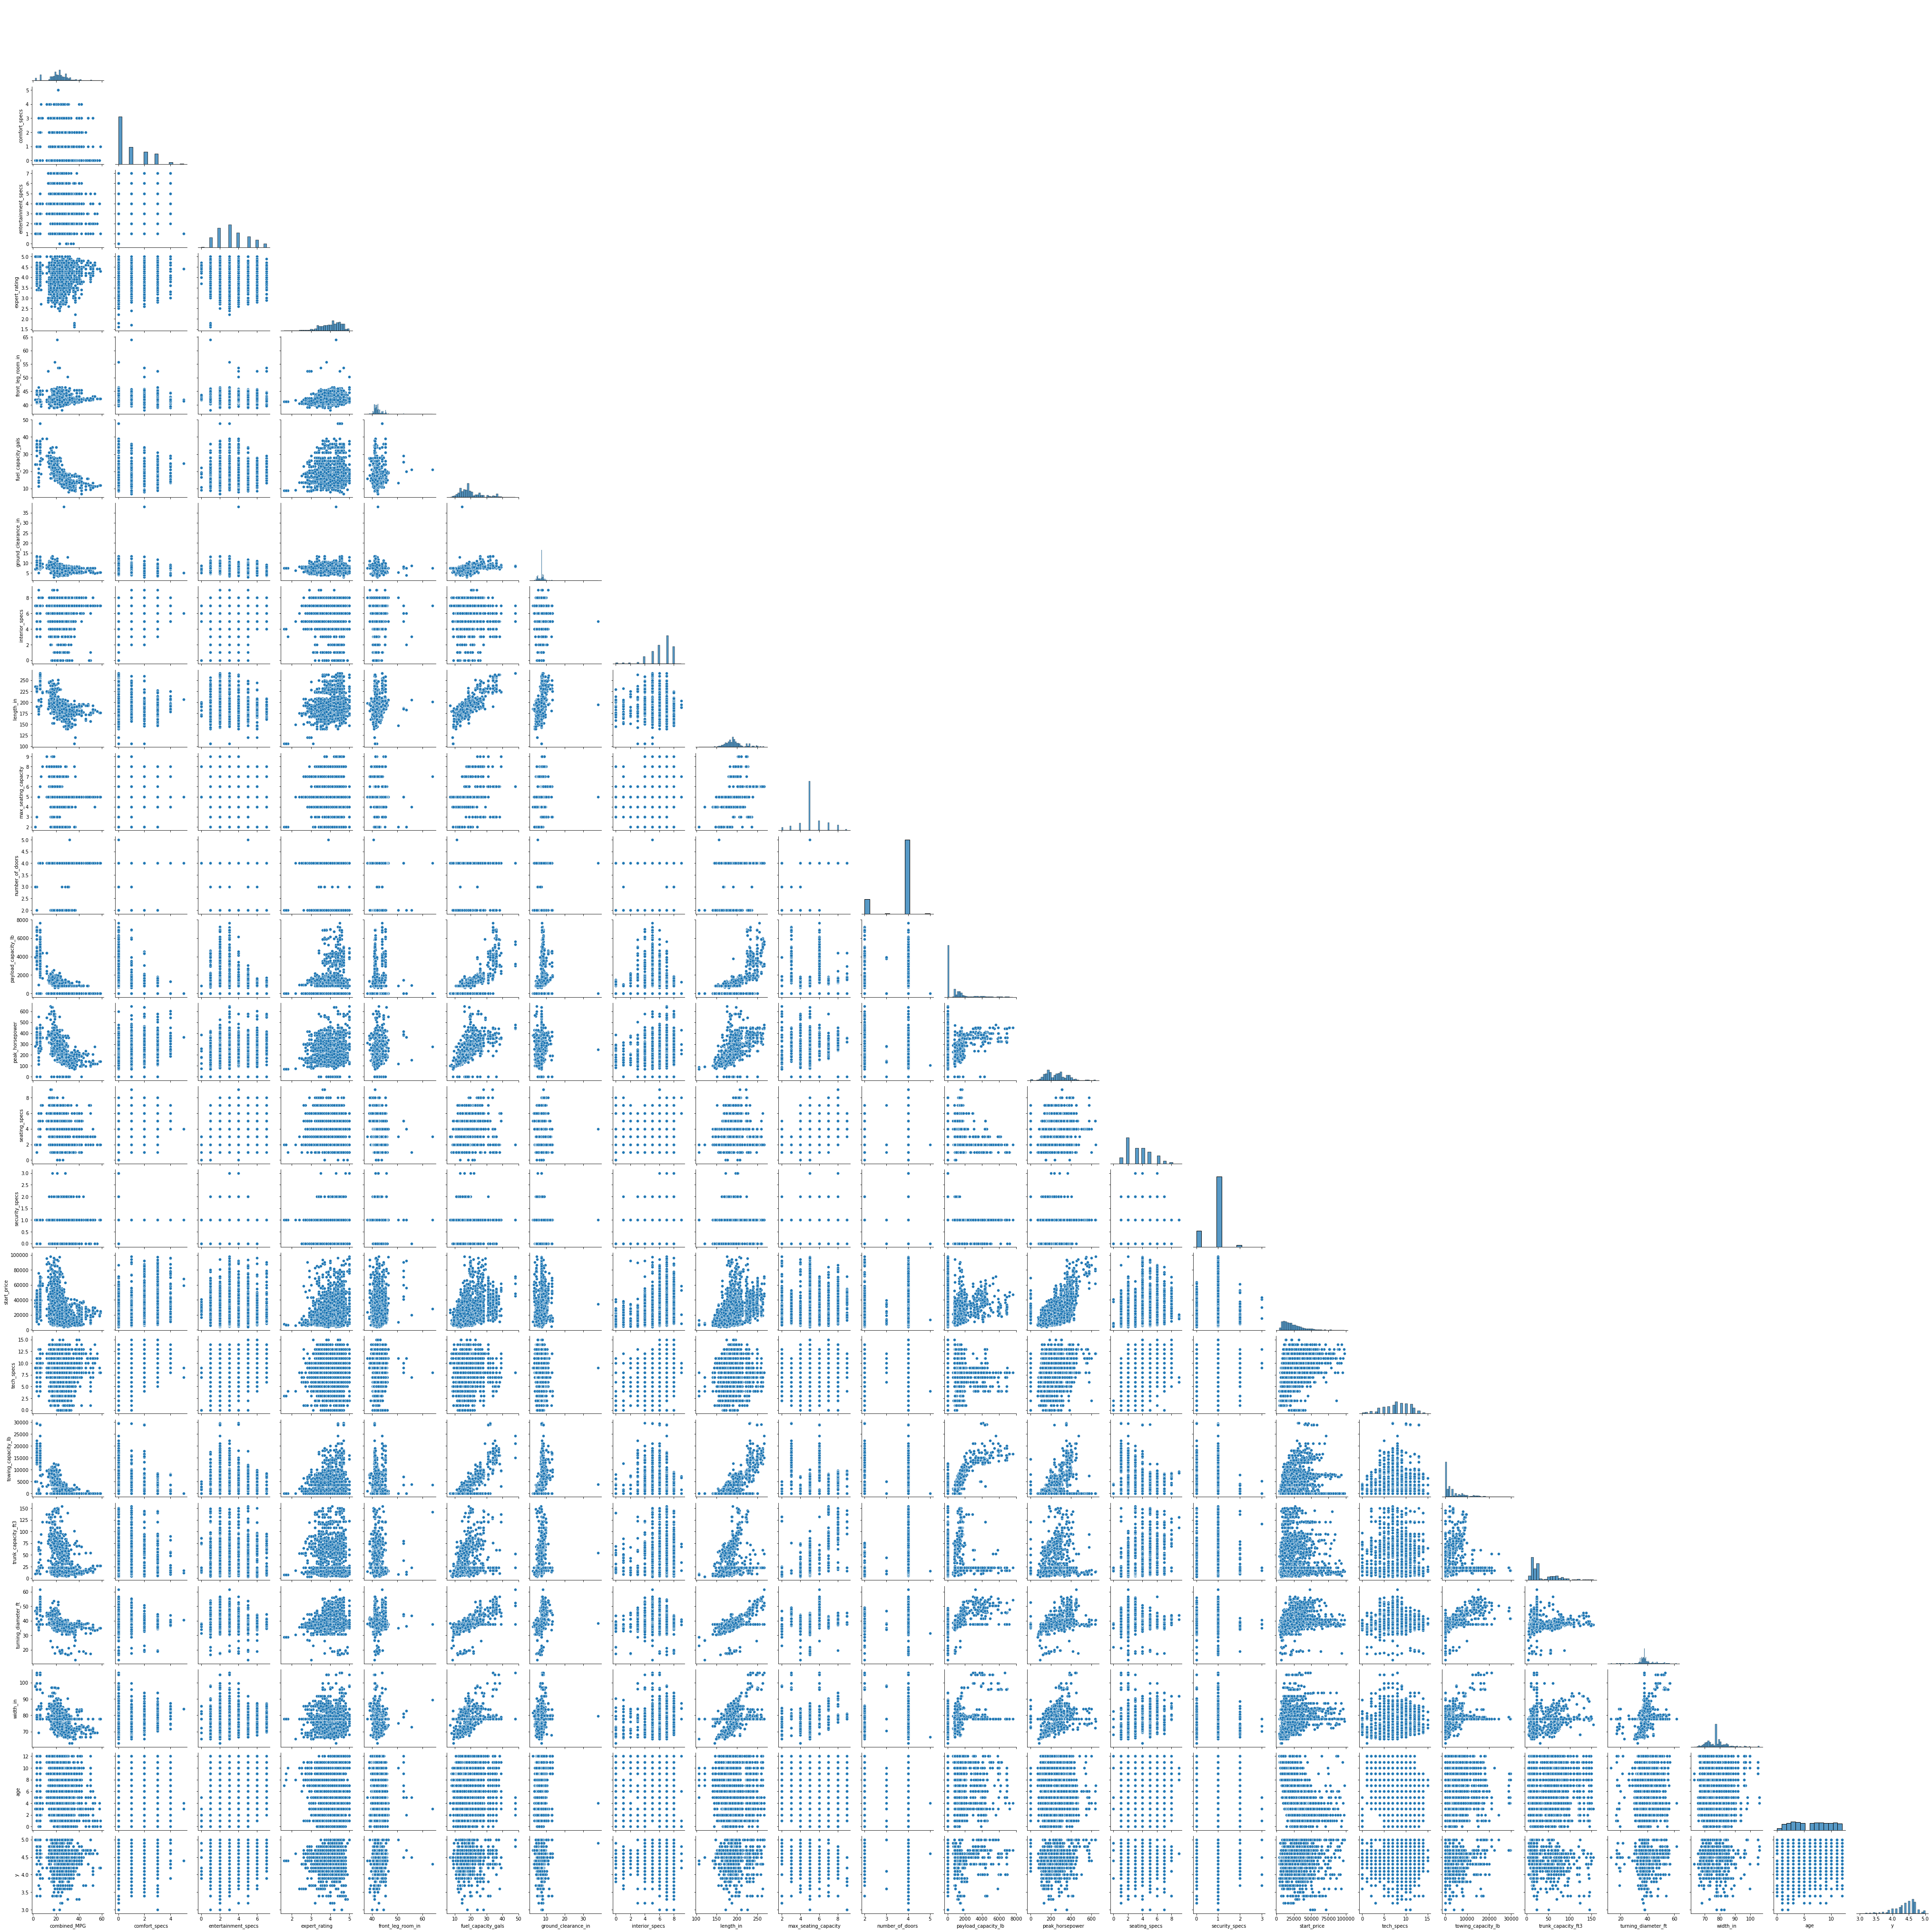

In [34]:
sns.pairplot(pairplot_train, corner=True)

<AxesSubplot:>

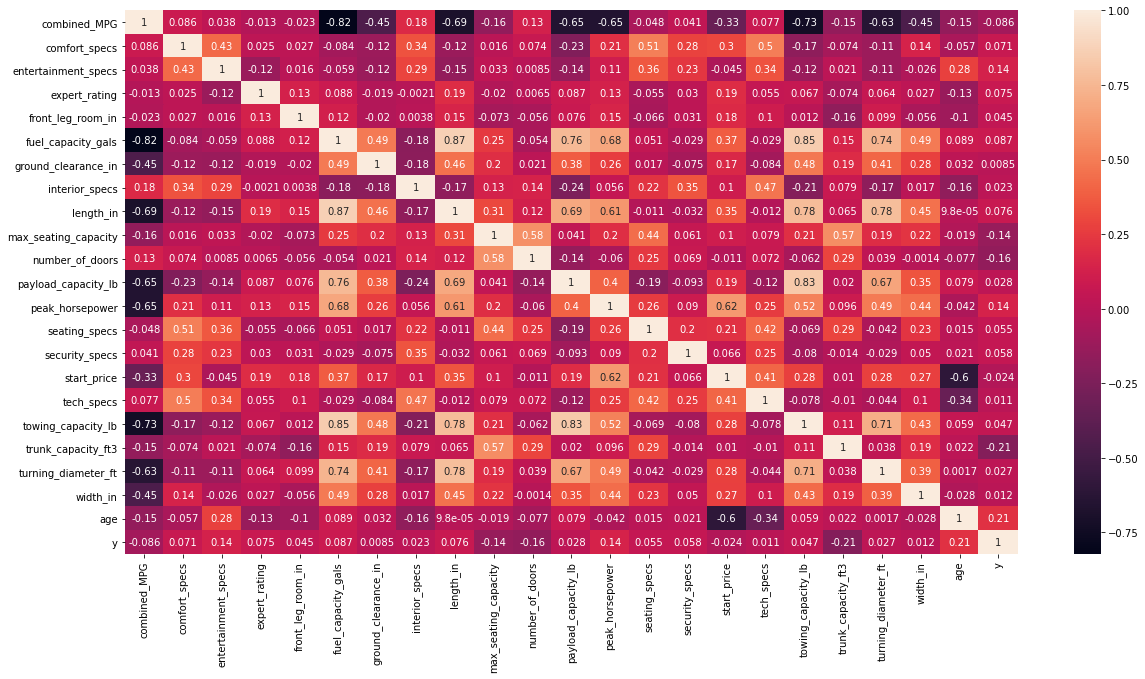

In [35]:
corrs = pairplot_train.corr()
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(corrs, cmap="rocket",annot=True, ax=ax)

Text(0.5, 0, 'Column Name')

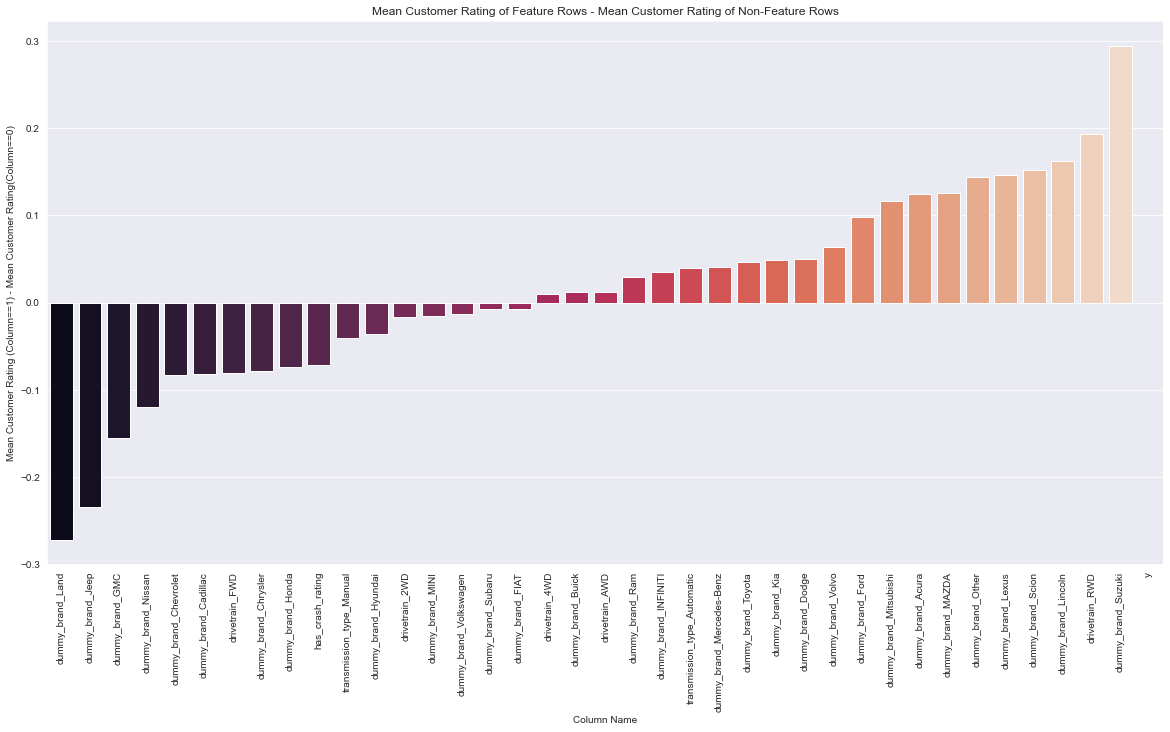

In [36]:
len(dummies.columns)

plt.rcParams.update({'figure.max_open_warning': 0})

differences = {}
for i, col in enumerate(dummies.columns):
    false_mean = np.mean(dummies.y[dummies[col]==0])
    true_mean = np.mean(dummies.y[dummies[col]==1])
    
    difference_in_means = true_mean - false_mean
    
    differences[col] = difference_in_means
    
    
diffs = {k: v for k, v in sorted(differences.items(), key=lambda item: item[1])}

keys = list(diffs.keys())
vals = list(diffs.values())

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x=keys, y=vals, ax=ax, palette="rocket")
ax.grid
ax.tick_params(axis='x', rotation=90)
ax.set_title('Mean Customer Rating of Feature Rows - Mean Customer Rating of Non-Feature Rows')
ax.set_ylabel('Mean Customer Rating (Column==1) - Mean Customer Rating(Column==0)')
ax.set_xlabel('Column Name')

Text(0.5, 0, 'Consumer Rating')

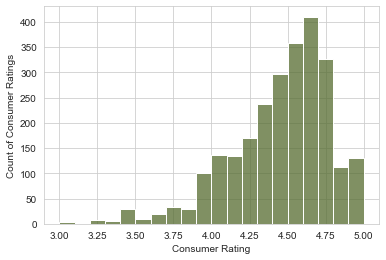

In [37]:
#other EDA for presentation
x_train['consumer_rating'] = y_train
sns.set_style("whitegrid")
sns.histplot(x_train.consumer_rating, bins=20, color="darkolivegreen")
plt.ylabel('Count of Consumer Ratings')
plt.xlabel('Consumer Rating')

## Building Cross Validation Capability 

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, Ridge, LinearRegression
import sklearn.metrics

In [39]:
def get_alpha_lasso(reg_x,y_train):
    kf = KFold(n_splits=5, shuffle=True, random_state=5)

    alpha = np.logspace(-4, 2, 100)
    param_grid = dict(alpha=alpha)
    lasso_model = LassoCV(alphas=alpha, cv=kf)
    lasso_model.fit(reg_x, y_train)
    best_alpha = lasso_model.alpha_
    return best_alpha
    
def get_alpha_ridge(reg_x,y_train):
    kf = KFold(n_splits=5, shuffle=True, random_state=5)

    alpha = np.logspace(-4, 2, 100)
    param_grid = dict(alpha=alpha)
    ridge_model = RidgeCV(alphas=alpha, cv=kf)
    ridge_model.fit(reg_x, y_train)
    best_alpha = ridge_model.alpha_
    return best_alpha

def cross_validate(x, y, model, model_type):
    kf = KFold(n_splits=5, shuffle=True, random_state=5)
    r2_scores = cross_val_score(model, x, y, cv=kf, scoring='r2')
    neg_mae_scores = cross_val_score(model, x, y, cv=kf, scoring='neg_mean_absolute_error')
    
    print('Model Name:', model_type)
    print('Cross-Validation R^2 Scores :', r2_scores)
    print('Average R^2 Score:', np.mean(r2_scores))
    print('Cross-Validation Neg MAE Scores:', neg_mae_scores)
    print('Average Neg MAE Score:', np.mean(neg_mae_scores))
    

def cross_val_graph(x,y,model,model_type):
    kf = KFold(n_splits=5, shuffle=True, random_state=5)
    predictions = cross_val_predict(model, x,y, cv=kf)
    sns.jointplot(x=predictions,y=y, kind='reg',joint_kws = {'scatter_kws':dict(alpha=0.3)}, color='darkolivegreen')
    
def plot_residuals(x,y,model,model_type):
    kf = KFold(n_splits=5, shuffle=True, random_state=5)
    predictions = cross_val_predict(model, x,y, cv=kf)
    residuals = y - predictions
    sns.jointplot(x=predictions,y=residuals, kind='reg',joint_kws = {'scatter_kws':dict(alpha=0.3)}, color='darkolivegreen')
    

## Baseline Model, All Features

In [40]:
baseline=LinearRegression()
baseline.fit(x_train_,y_train)
cross_validate(x_train_,y_train, baseline, "Simple Linear Regression")

Model Name: Simple Linear Regression
Cross-Validation R^2 Scores : [0.23044976 0.16801423 0.2805234  0.17267407 0.22673655]
Average R^2 Score: 0.21567960293011845
Cross-Validation Neg MAE Scores: [-0.21253551 -0.22353725 -0.21410029 -0.22528011 -0.22774061]
Average Neg MAE Score: -0.22063875418931533


## Using Lasso for Feature Selection

In [41]:
#first, regularize all non-dummy numerical columns 

x_train_ = x_train_.reset_index().drop('index', axis=1)
x_test_ = x_test_.reset_index().drop('index', axis=1)

xtrain_ready_for_regular = x_train_[['combined_MPG', 'comfort_specs', 'entertainment_specs', 'expert_rating',
                             'front_leg_room_in', 'fuel_capacity_gals', 'ground_clearance_in', 'interior_specs',
                             'length_in', 'max_seating_capacity', 'number_of_doors', 'payload_capacity_lb', 'peak_horsepower',
                             'seating_specs', 'security_specs', 'start_price', 'tech_specs', 'towing_capacity_lb',
                             'trunk_capacity_ft3', 'turning_diameter_ft', 'width_in', 'age']]

dummies_xtrain = x_train_[x_train_.columns.difference(['combined_MPG', 'comfort_specs', 'entertainment_specs', 'expert_rating',
                             'front_leg_room_in', 'fuel_capacity_gals', 'ground_clearance_in', 'interior_specs',
                             'length_in', 'max_seating_capacity', 'number_of_doors', 'payload_capacity_lb', 'peak_horsepower',
                             'seating_specs', 'security_specs', 'start_price', 'tech_specs', 'towing_capacity_lb',
                             'trunk_capacity_ft3', 'turning_diameter_ft', 'width_in', 'age', 'brand', 'fuel_type','name'])]

xtest_ready_for_regular = x_test_[['combined_MPG', 'comfort_specs', 'entertainment_specs', 'expert_rating',
                             'front_leg_room_in', 'fuel_capacity_gals', 'ground_clearance_in', 'interior_specs',
                             'length_in', 'max_seating_capacity', 'number_of_doors', 'payload_capacity_lb', 'peak_horsepower',
                             'seating_specs', 'security_specs', 'start_price', 'tech_specs', 'towing_capacity_lb',
                             'trunk_capacity_ft3', 'turning_diameter_ft', 'width_in', 'age']]

dummies_xtest = x_test_[x_test_.columns.difference(['combined_MPG', 'comfort_specs', 'entertainment_specs', 'expert_rating',
                             'front_leg_room_in', 'fuel_capacity_gals', 'ground_clearance_in', 'interior_specs',
                             'length_in', 'max_seating_capacity', 'number_of_doors', 'payload_capacity_lb', 'peak_horsepower',
                             'seating_specs', 'security_specs', 'start_price', 'tech_specs', 'towing_capacity_lb',
                             'trunk_capacity_ft3', 'turning_diameter_ft', 'width_in', 'age', 'brand', 'fuel_type','name'])]




std = StandardScaler()
std.fit(xtrain_ready_for_regular)

xtrain_reg = std.transform(xtrain_ready_for_regular.values)
xtest_reg = std.transform(xtest_ready_for_regular.values)

In [42]:
xtrain_reg = pd.DataFrame(xtrain_reg, columns=xtrain_ready_for_regular.columns)
xtest_reg = pd.DataFrame(xtest_reg, columns=xtest_ready_for_regular.columns)


In [43]:
regular_xtrain = pd.concat([xtrain_reg, dummies_xtrain], axis=1)
regular_xtest = pd.concat([xtest_reg, dummies_xtest], axis=1)

Model Name: Lasso
Cross-Validation R^2 Scores : [0.23874664 0.17606605 0.27109609 0.1763766  0.22429667]
Average R^2 Score: 0.21731640829291834
Cross-Validation Neg MAE Scores: [-0.21147487 -0.22212546 -0.21572    -0.22489684 -0.2280327 ]
Average Neg MAE Score: -0.22044997368952943


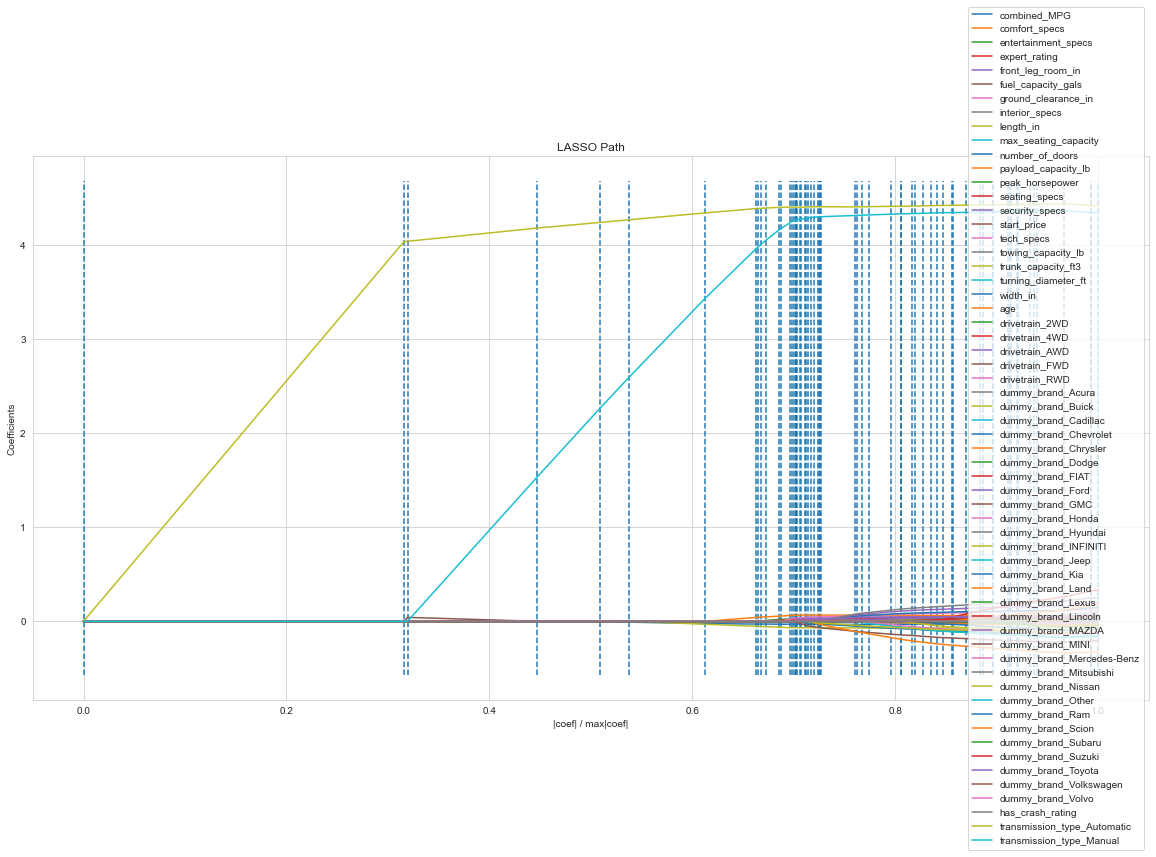

In [44]:
#iteration 1 of lasso/lars path feature selection

lasso_alpha = get_alpha_lasso(regular_xtrain, y_train)
lasso_lr = Lasso(alpha=lasso_alpha)
lasso_lr.fit(regular_xtrain, y_train)
cross_validate(regular_xtrain, y_train, lasso_lr, "Lasso")
#first lars path iteration

from sklearn.linear_model import lars_path

regular_xtrain_np = regular_xtrain.to_numpy()
alphas, _, coefs = lars_path(regular_xtrain_np, y_train.values, method='lasso')

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(20,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(regular_xtrain.columns,loc= 'right')
plt.show()

In [45]:
#which features did the lars path squash?
coefs = lasso_lr.coef_
importance = np.abs(coefs)
not_important = list(np.array(regular_xtrain.columns)[importance == 0])
print(not_important)
#remove these from train and test
x_train_ = x_train_[x_train_.columns.difference(not_important)]
x_test_ = x_test_[x_test_.columns.difference(not_important)]
regular_xtrain = regular_xtrain[regular_xtrain.columns.difference(not_important)]
regular_xtest = regular_xtest[regular_xtest.columns.difference(not_important)]



['front_leg_room_in', 'drivetrain_4WD', 'dummy_brand_Honda', 'dummy_brand_MINI', 'dummy_brand_Other', 'dummy_brand_Subaru', 'dummy_brand_Volkswagen', 'transmission_type_Manual']


Model Name: Lasso
Cross-Validation R^2 Scores : [0.23996142 0.17680235 0.27119628 0.17706906 0.22547238]
Average R^2 Score: 0.2181002949556147
Cross-Validation Neg MAE Scores: [-0.21139556 -0.2219045  -0.21572204 -0.22460348 -0.22799889]
Average Neg MAE Score: -0.22032489525308935


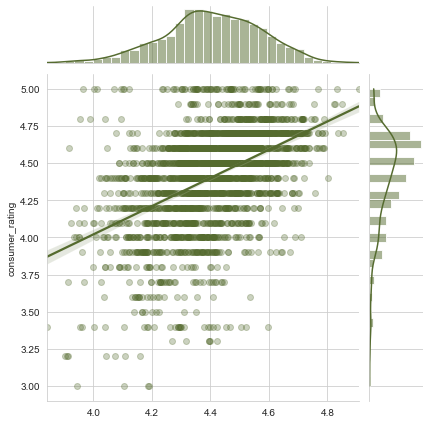

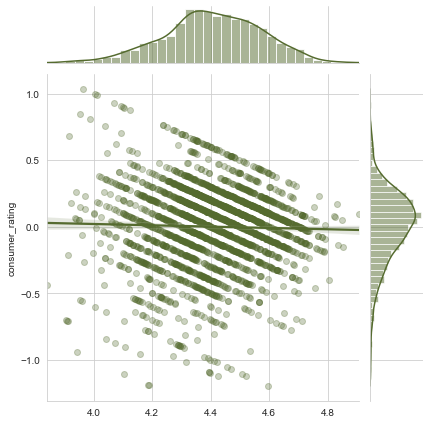

In [46]:
#iteration 2 of lasso/lars path feature selection

lasso_alpha2 = get_alpha_lasso(regular_xtrain, y_train)
lasso_lr2 = Lasso(alpha=lasso_alpha)
lasso_lr2.fit(regular_xtrain, y_train)
cross_validate(regular_xtrain, y_train, lasso_lr2, "Lasso")
cross_val_graph(regular_xtrain,y_train,lasso_lr2, "Lasso")
plot_residuals(regular_xtrain,y_train,lasso_lr2, "Lasso")

In [47]:
#which features did the lars path squash?
coefs = lasso_lr2.coef_
importance = np.abs(coefs)
not_important = list(np.array(regular_xtrain.columns)[importance == 0])
not_important
#it didn't squash any. let's move on with these features to figure out what kind of
#model will work best 

[]

## Choosing Model Type

In [48]:
lasso_a = get_alpha_lasso(regular_xtrain, y_train)
ridge_a = get_alpha_ridge(regular_xtrain, y_train)

lasso_reg = Lasso(alpha=lasso_a)
lasso_reg.fit(regular_xtrain, y_train)
cross_validate(regular_xtrain, y_train, lasso_reg, "Lasso")
print('\n')

ridge_reg = Ridge(alpha=ridge_a)
ridge_reg.fit(regular_xtrain, y_train)
cross_validate(regular_xtrain, y_train, ridge_reg, "Ridge")
print('\n')

simple_reg = LinearRegression()
simple_reg.fit(x_train_, y_train)
cross_validate(x_train_, y_train, simple_reg, "Simple Linear Regression")

Model Name: Lasso
Cross-Validation R^2 Scores : [0.2366614  0.17397317 0.27642225 0.17627817 0.22808798]
Average R^2 Score: 0.21828459229381494
Cross-Validation Neg MAE Scores: [-0.21171785 -0.22238519 -0.21497275 -0.22455868 -0.22773951]
Average Neg MAE Score: -0.22027479514378787


Model Name: Ridge
Cross-Validation R^2 Scores : [0.23930524 0.17527244 0.27643205 0.1783056  0.22531973]
Average R^2 Score: 0.21892701197422476
Cross-Validation Neg MAE Scores: [-0.2113114  -0.2224154  -0.21504881 -0.22430325 -0.22822164]
Average Neg MAE Score: -0.2202601018833552


Model Name: Simple Linear Regression
Cross-Validation R^2 Scores : [0.23206163 0.1701997  0.28134968 0.17398356 0.22990998]
Average R^2 Score: 0.21750090965621585
Cross-Validation Neg MAE Scores: [-0.21241335 -0.22296993 -0.21426515 -0.22476119 -0.22766218]
Average Neg MAE Score: -0.22041435814117682


## Feature Engineering 

In [49]:
x_train2 = x_train_[x_train_.columns.difference(['front_leg_room_in', 'drivetrain_4WD', 'dummy_brand_Honda', 'dummy_brand_MINI', 
                                                 'dummy_brand_Other', 'dummy_brand_Subaru', 'dummy_brand_Volkswagen', 'transmission_type_Manual'])]
regular_xtrain2 = regular_xtrain[regular_xtrain.columns.difference(['front_leg_room_in', 'drivetrain_4WD', 'dummy_brand_Honda', 'dummy_brand_MINI', 
                   'dummy_brand_Other', 'dummy_brand_Subaru', 'dummy_brand_Volkswagen', 'transmission_type_Manual'])]

regular_xtest2 = regular_xtest[regular_xtest.columns.difference(['front_leg_room_in', 'drivetrain_4WD', 'dummy_brand_Honda', 'dummy_brand_MINI', 
                   'dummy_brand_Other', 'dummy_brand_Subaru', 'dummy_brand_Volkswagen', 'transmission_type_Manual'])]
x_test2 = x_test_[x_test_.columns.difference(['front_leg_room_in', 'drivetrain_4WD', 'dummy_brand_Honda', 'dummy_brand_MINI', 
                   'dummy_brand_Other', 'dummy_brand_Subaru', 'dummy_brand_Volkswagen', 'transmission_type_Manual'])]


In [50]:
# affect of removing squashed columns
lasso_a = get_alpha_lasso(regular_xtrain2, y_train)
ridge_a = get_alpha_ridge(regular_xtrain2, y_train)

lasso_reg = Lasso(alpha=lasso_a)
lasso_reg.fit(regular_xtrain2, y_train)
cross_validate(regular_xtrain2, y_train, lasso_reg, "Lasso")
print('\n')

ridge_reg = Ridge(alpha=ridge_a)
ridge_reg.fit(regular_xtrain2, y_train)
cross_validate(regular_xtrain2, y_train, ridge_reg, "Ridge")
print('\n')

simple_reg = LinearRegression()
simple_reg.fit(x_train2, y_train)
cross_validate(x_train2, y_train, simple_reg, "Simple Linear Regression")

Model Name: Lasso
Cross-Validation R^2 Scores : [0.2366614  0.17397317 0.27642225 0.17627817 0.22808798]
Average R^2 Score: 0.21828459229381494
Cross-Validation Neg MAE Scores: [-0.21171785 -0.22238519 -0.21497275 -0.22455868 -0.22773951]
Average Neg MAE Score: -0.22027479514378787


Model Name: Ridge
Cross-Validation R^2 Scores : [0.23930524 0.17527244 0.27643205 0.1783056  0.22531973]
Average R^2 Score: 0.21892701197422476
Cross-Validation Neg MAE Scores: [-0.2113114  -0.2224154  -0.21504881 -0.22430325 -0.22822164]
Average Neg MAE Score: -0.2202601018833552


Model Name: Simple Linear Regression
Cross-Validation R^2 Scores : [0.23206163 0.1701997  0.28134968 0.17398356 0.22990998]
Average R^2 Score: 0.21750090965621585
Cross-Validation Neg MAE Scores: [-0.21241335 -0.22296993 -0.21426515 -0.22476119 -0.22766218]
Average Neg MAE Score: -0.22041435814117682


In [51]:
def start_price_category(row):
    if (row>=0) & (row<= 20000):
        return "0-20000"
    elif (row>20000) & (row<=40000):
        return "20000-40000"
    elif (row>40000) & (row<=60000):
        return "40000-60000"
    elif (row > 60000) & (row<= 80000):
        return "60000-80000"
    elif (row>80000) & (row<=100000):
        return "80000-100000"

def add_deviation_feature(X, feature, category):
    
    # temp groupby object
    category_gb = X.groupby(category)[feature]
    
    # create columns of category means and standard deviations
    category_mean = category_gb.transform(lambda x: x.mean())
    category_std = category_gb.transform(lambda x: x.std())
    
    # compute stds from category mean for each feature value,
    # add to X as new feature
    deviation_feature = (X[feature] - category_mean) / category_std 
    X[feature + '_Dev_' + category] = deviation_feature
    



In [52]:
##increased r^2 by ~.01, MAE down by .0005
x_train2['combined_MPG_2'] = x_train2.combined_MPG ** 2
regular_xtrain2['combined_MPG_2'] = regular_xtrain2.combined_MPG ** 2
regular_xtest2['combined_MPG_2'] = regular_xtest2.combined_MPG **2 
x_test2['combined_MPG_2'] = x_test2.combined_MPG **2

#increased r^2 by .004, mae down by .0004
x_train2['entertainment_specs_2'] = x_train2.entertainment_specs **2
regular_xtrain2['entertainment_specs_2'] = regular_xtrain2.entertainment_specs **2
regular_xtest2['entertainment_specs_2'] = regular_xtest2.entertainment_specs **2 
x_test2['entertainment_specs_2'] = x_test2.entertainment_specs**2


In [53]:
# try the models with each new feature 
lasso_a = get_alpha_lasso(regular_xtrain2, y_train)
ridge_a = get_alpha_ridge(regular_xtrain2, y_train)

lasso_reg = Lasso(alpha=lasso_a)
lasso_reg.fit(regular_xtrain2, y_train)
cross_validate(regular_xtrain2, y_train, lasso_reg, "Lasso")
print('\n')

ridge_reg = Ridge(alpha=ridge_a)
ridge_reg.fit(regular_xtrain2, y_train)
cross_validate(regular_xtrain2, y_train, ridge_reg, "Ridge")
print('\n')

simple_reg = LinearRegression()
simple_reg.fit(x_train2, y_train)
cross_validate(x_train2, y_train, simple_reg, "Simple Linear Regression")

Model Name: Lasso
Cross-Validation R^2 Scores : [0.25630334 0.19480794 0.2719622  0.18768232 0.24140986]
Average R^2 Score: 0.23043313118396364
Cross-Validation Neg MAE Scores: [-0.21064582 -0.21963789 -0.21648769 -0.2229614  -0.22677142]
Average Neg MAE Score: -0.21930084609771622


Model Name: Ridge
Cross-Validation R^2 Scores : [0.25760126 0.1946328  0.27194705 0.18934732 0.23955793]
Average R^2 Score: 0.2306172726943183
Cross-Validation Neg MAE Scores: [-0.21034279 -0.21983071 -0.21655252 -0.22263358 -0.22710167]
Average Neg MAE Score: -0.219292254148358


Model Name: Simple Linear Regression
Cross-Validation R^2 Scores : [0.25102165 0.19035428 0.27662052 0.18459316 0.2438514 ]
Average R^2 Score: 0.22928820022777568
Cross-Validation Neg MAE Scores: [-0.21137005 -0.22032669 -0.21564133 -0.22330863 -0.22642496]
Average Neg MAE Score: -0.2194143317862361


## Addressing Multicollinearity

In [54]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

#use VIF to find the columns that are causing multicollinearity

x_train3 = x_train2.copy()
regular_xtrain3 = regular_xtrain2.copy()
regular_xtest3 = regular_xtest2.copy()
x_test3 = x_test2.copy()
def vif(df_x):
    '''
    Calculate the VIF for each feature of df_x (a Pandas DataFrame).
    '''
    vif_data = [variance_inflation_factor(df_x.values, i)
                for i in range(df_x.shape[1])]
    
    return pd.Series(vif_data, index=df_x.columns)   

vif(x_train3)                                    

age                             14.206441
combined_MPG                   202.685596
comfort_specs                    4.395693
drivetrain_2WD                   2.759693
drivetrain_AWD                   3.548832
drivetrain_FWD                  10.643884
drivetrain_RWD                   4.157644
dummy_brand_Acura                1.338217
dummy_brand_Buick                1.263340
dummy_brand_Cadillac             1.503076
dummy_brand_Chevrolet            2.292757
dummy_brand_Chrysler             1.223558
dummy_brand_Dodge                1.370595
dummy_brand_FIAT                 1.228519
dummy_brand_Ford                 2.410517
dummy_brand_GMC                  2.054962
dummy_brand_Hyundai              1.531816
dummy_brand_INFINITI             1.390133
dummy_brand_Jeep                 1.500473
dummy_brand_Kia                  1.449659
dummy_brand_Land                 1.597361
dummy_brand_Lexus                1.589361
dummy_brand_Lincoln              1.484978
dummy_brand_MAZDA                1

In [55]:
x_train3 = x_train3[x_train3.columns.difference(['length_in','width_in','turning_diameter_ft','tech_specs',
                                                 'interior_specs','start_price','towing_capacity_lb','comfort_specs',
                                                 'drivetrain_2WD','drivetrain_FWD','dummy_brand_Acura', 'dummy_brand_Buick'
                                                 ,'dummy_brand_Chrysler','dummy_brand_FIAT','dummy_brand_Ford'
                                                ,'dummy_brand_Lexus','dummy_brand_Lincoln','dummy_brand_Toyota'
                                                ,'dummy_brand_Volvo','has_crash_rating','security_specs'])] 
                                           
regular_xtrain3 = regular_xtrain3[regular_xtrain3.columns.difference(['length_in','width_in', 'turning_diameter_ft',
                                                                     'tech_specs','interior_specs','start_price',
                                                                      'towing_capacity_lb','comfort_specs','drivetrain_2WD'
                                                                      ,'drivetrain_FWD','dummy_brand_Acura','dummy_brand_Buick'
                                                                      ,'dummy_brand_Chrysler','dummy_brand_FIAT','dummy_brand_Ford'
                                                                    ,'dummy_brand_Lexus','dummy_brand_Lincoln','dummy_brand_Toyota'
                                                                     ,'dummy_brand_Volvo','has_crash_rating','security_specs'])]

regular_xtest3 = regular_xtest3[regular_xtrain3.columns.difference(['length_in','width_in', 'turning_diameter_ft',
                                                                     'tech_specs','interior_specs','start_price',
                                                                      'towing_capacity_lb','comfort_specs','drivetrain_2WD'
                                                                      ,'drivetrain_FWD','dummy_brand_Acura','dummy_brand_Buick'
                                                                      ,'dummy_brand_Chrysler','dummy_brand_FIAT','dummy_brand_Ford'
                                                                    ,'dummy_brand_Lexus','dummy_brand_Lincoln','dummy_brand_Toyota'
                                                                     ,'dummy_brand_Volvo','has_crash_rating','security_specs'])]

x_test3 = x_test3[x_test3.columns.difference(['length_in','width_in', 'turning_diameter_ft',
                                                                     'tech_specs','interior_specs','start_price',
                                                                      'towing_capacity_lb','comfort_specs','drivetrain_2WD'
                                                                      ,'drivetrain_FWD','dummy_brand_Acura','dummy_brand_Buick'
                                                                      ,'dummy_brand_Chrysler','dummy_brand_FIAT','dummy_brand_Ford'
                                                                    ,'dummy_brand_Lexus','dummy_brand_Lincoln','dummy_brand_Toyota'
                                                                     ,'dummy_brand_Volvo','has_crash_rating','security_specs'])]


vif(x_train3)

age                              5.536274
combined_MPG                   123.635209
combined_MPG_2                  35.311872
drivetrain_AWD                   1.566608
drivetrain_RWD                   1.841249
dummy_brand_Cadillac             1.150840
dummy_brand_Chevrolet            1.385057
dummy_brand_Dodge                1.118106
dummy_brand_GMC                  1.381385
dummy_brand_Hyundai              1.172018
dummy_brand_INFINITI             1.180430
dummy_brand_Jeep                 1.119367
dummy_brand_Kia                  1.170697
dummy_brand_Land                 1.138937
dummy_brand_MAZDA                1.135968
dummy_brand_Mercedes-Benz        1.679857
dummy_brand_Mitsubishi           1.100199
dummy_brand_Nissan               1.217664
dummy_brand_Ram                  1.373097
dummy_brand_Scion                1.074277
dummy_brand_Suzuki               1.063605
entertainment_specs            101.642852
entertainment_specs_2           42.258500
expert_rating                   62

Model Name: Lasso
Cross-Validation R^2 Scores : [0.25941828 0.21497773 0.27304516 0.19941038 0.25145961]
Average R^2 Score: 0.2396622313731414
Cross-Validation Neg MAE Scores: [-0.21182446 -0.21620035 -0.21644039 -0.22092087 -0.22480818]
Average Neg MAE Score: -0.21803884987398608


Model Name: Ridge
Cross-Validation R^2 Scores : [0.26110373 0.21731538 0.2727494  0.20090142 0.24924382]
Average R^2 Score: 0.2402627514345732
Cross-Validation Neg MAE Scores: [-0.21137519 -0.215979   -0.21660521 -0.22081907 -0.22513518]
Average Neg MAE Score: -0.2179827314942194


Model Name: Simple Linear Regression
Cross-Validation R^2 Scores : [0.25755983 0.21396222 0.27426728 0.19905425 0.25322336]
Average R^2 Score: 0.23961338719158382
Cross-Validation Neg MAE Scores: [-0.21223641 -0.21624597 -0.21617523 -0.22089811 -0.22461036]
Average Neg MAE Score: -0.2180332164914726


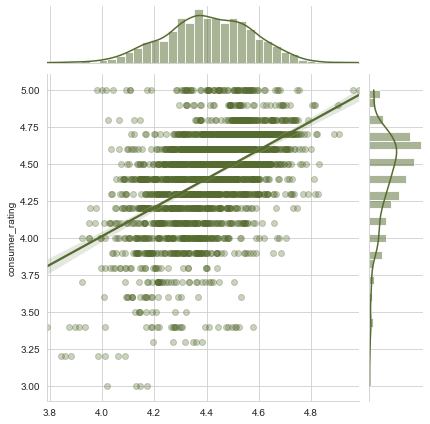

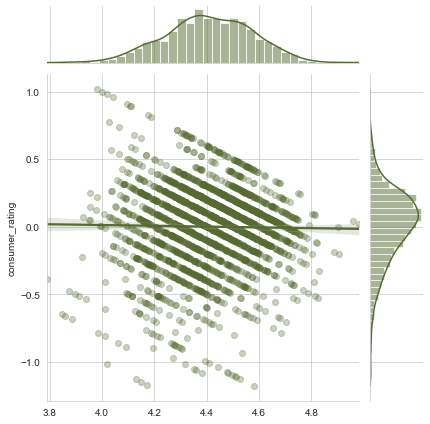

In [56]:
#attempt another model post-VIF analysis

lasso_a = get_alpha_lasso(regular_xtrain3, y_train)
ridge_a = get_alpha_ridge(regular_xtrain3, y_train)

lasso_reg_f = Lasso(alpha=lasso_a)
lasso_reg_f.fit(regular_xtrain3, y_train)
cross_validate(regular_xtrain3, y_train, lasso_reg_f, "Lasso")
#cross_val_graph(regular_xtrain3,y_train,lasso_reg, "Lasso")
print('\n')

ridge_reg_f = Ridge(alpha=ridge_a)
ridge_reg_f.fit(regular_xtrain3, y_train)
cross_validate(regular_xtrain3, y_train, ridge_reg_f, "Ridge")
cross_val_graph(regular_xtrain3,y_train,ridge_reg_f, "Ridge")
plot_residuals(regular_xtrain3,y_train,ridge_reg_f, "Ridge")
print('\n')

simple_reg_f = LinearRegression()
simple_reg_f.fit(x_train3, y_train)
cross_validate(x_train3, y_train, simple_reg_f, "Simple Linear Regression")
#cross_val_graph(regular_xtrain,y_train,simple_reg, "Simple Linear Regression")

In [57]:
#print('Feature coefficient results for the most recent Ridge model)
for feature, coef in zip(regular_xtrain3.columns, ridge_reg_f.coef_):
    print(feature, ':', f'{coef:.2f}')

age : 0.06
combined_MPG : -0.03
combined_MPG_2 : 0.02
drivetrain_AWD : 0.05
drivetrain_RWD : 0.11
dummy_brand_Cadillac : -0.20
dummy_brand_Chevrolet : -0.15
dummy_brand_Dodge : -0.08
dummy_brand_GMC : -0.24
dummy_brand_Hyundai : -0.05
dummy_brand_INFINITI : -0.18
dummy_brand_Jeep : -0.18
dummy_brand_Kia : 0.10
dummy_brand_Land : -0.37
dummy_brand_MAZDA : 0.15
dummy_brand_Mercedes-Benz : -0.19
dummy_brand_Mitsubishi : 0.18
dummy_brand_Nissan : -0.14
dummy_brand_Ram : -0.14
dummy_brand_Scion : 0.10
dummy_brand_Suzuki : 0.20
entertainment_specs : 0.01
entertainment_specs_2 : 0.02
expert_rating : 0.02
fuel_capacity_gals : 0.04
ground_clearance_in : 0.03
max_seating_capacity : -0.02
number_of_doors : -0.02
payload_capacity_lb : -0.05
peak_horsepower : 0.04
seating_specs : 0.04
transmission_type_Automatic : 0.07
trunk_capacity_ft3 : -0.07


## Final Test on Holdout Set

Final Ridge Regression R^2: 0.21834473649635033
Final Ridge Regression MAE: 0.23034418397654438


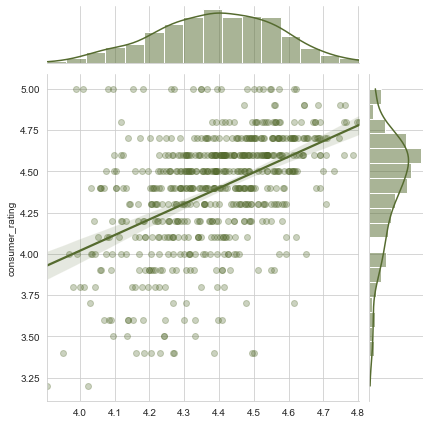

In [58]:
from sklearn.metrics import mean_absolute_error
#ridge model
ridge_reg_f.fit(regular_xtrain3, y_train)
ridge_preds = ridge_reg_f.predict(regular_xtest3)
print('Final Ridge Regression R^2:', ridge_reg_f.score(regular_xtest3, y_test))
print('Final Ridge Regression MAE:', mean_absolute_error(y_test, ridge_preds))


sns.jointplot(x=ridge_preds,y=y_test, kind='reg',joint_kws = {'scatter_kws':dict(alpha=0.3)}, color='darkolivegreen')
    

Final Lasso Regression R^2: 0.21864953769857975
Final Lasso Regression MAE: 0.23031774271080646


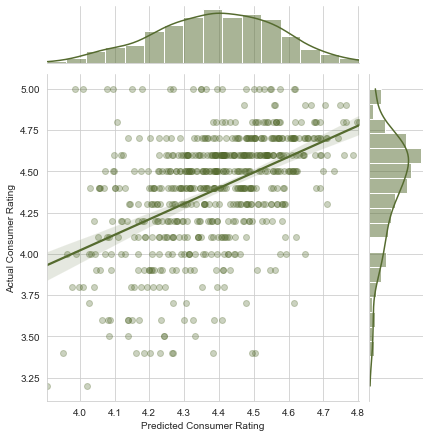

In [59]:
#lasso model
lasso_reg_f.fit(regular_xtrain3, y_train)
lasso_preds = lasso_reg_f.predict(regular_xtest3)
print('Final Lasso Regression R^2:', lasso_reg_f.score(regular_xtest3, y_test))
print('Final Lasso Regression MAE:', mean_absolute_error(y_test,lasso_preds))


plot=sns.jointplot(x=lasso_preds,y=y_test, kind='reg',joint_kws = {'scatter_kws':dict(alpha=0.3)}, color='darkolivegreen')
plot.set_axis_labels('Predicted Consumer Rating', 'Actual Consumer Rating', fontsize=10)


Final Simple Regression R^2: 0.21883261857448344
Final Simple Regression MAE: 0.2301536081448611


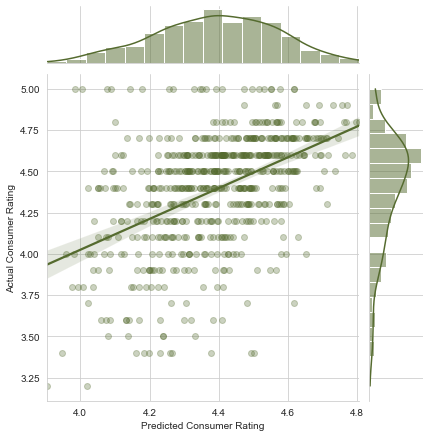

In [60]:
#simple model
simple_reg_f.fit(x_train3, y_train)
simple_preds = simple_reg_f.predict(x_test3)
print('Final Simple Regression R^2:', simple_reg_f.score(x_test3, y_test))
print('Final Simple Regression MAE:', mean_absolute_error(y_test,simple_preds))


plot = sns.jointplot(x=simple_preds,y=y_test, kind='reg',joint_kws = {'scatter_kws':dict(alpha=0.3)}, color='darkolivegreen')
plot.set_axis_labels('Predicted Consumer Rating', 'Actual Consumer Rating', fontsize=10)


In [61]:
coef_dict={}
for feature, coef in zip(regular_xtrain3.columns, lasso_reg_f.coef_):
    coef_dict[feature]=coef
    print(feature, ':', f'{coef:.5f}')

age : 0.06294
combined_MPG : -0.03116
combined_MPG_2 : 0.02442
drivetrain_AWD : 0.04614
drivetrain_RWD : 0.10922
dummy_brand_Cadillac : -0.20529
dummy_brand_Chevrolet : -0.15527
dummy_brand_Dodge : -0.07822
dummy_brand_GMC : -0.24470
dummy_brand_Hyundai : -0.05240
dummy_brand_INFINITI : -0.18407
dummy_brand_Jeep : -0.18890
dummy_brand_Kia : 0.09492
dummy_brand_Land : -0.38312
dummy_brand_MAZDA : 0.14940
dummy_brand_Mercedes-Benz : -0.19519
dummy_brand_Mitsubishi : 0.17921
dummy_brand_Nissan : -0.13947
dummy_brand_Ram : -0.14160
dummy_brand_Scion : 0.10015
dummy_brand_Suzuki : 0.22386
entertainment_specs : 0.01132
entertainment_specs_2 : 0.01870
expert_rating : 0.01841
fuel_capacity_gals : 0.04457
ground_clearance_in : 0.02551
max_seating_capacity : -0.02459
number_of_doors : -0.02405
payload_capacity_lb : -0.05015
peak_horsepower : 0.03536
seating_specs : 0.04286
transmission_type_Automatic : 0.06879
trunk_capacity_ft3 : -0.06538


Text(0, 0.5, 'Lasso Regression Coefficient')

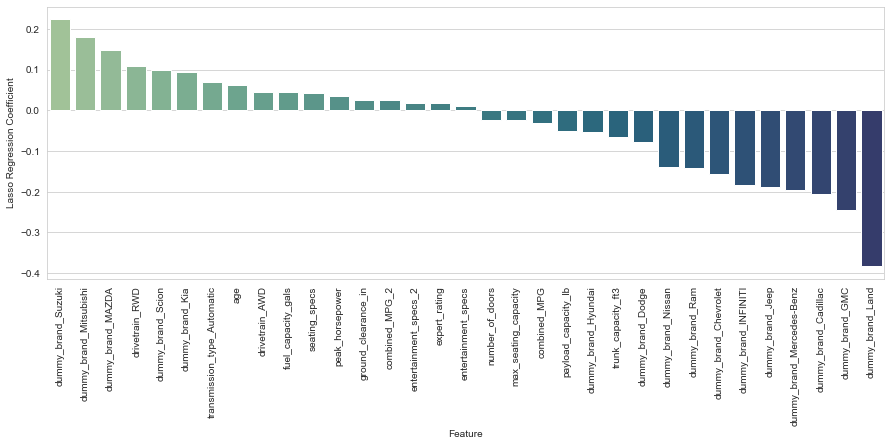

In [62]:
coef_plot = {k: v for k, v in sorted(coef_dict.items(), reverse=True, key=lambda item: item[1])}
plt.figure(figsize=(15,5))
sns.barplot(list(coef_plot.keys()), list(coef_plot.values()), palette="crest")
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Lasso Regression Coefficient')


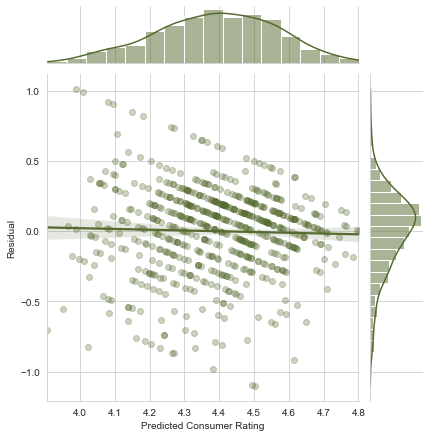

In [63]:
lasso_residuals = y_test - lasso_preds
plot=sns.jointplot(x=lasso_preds,y=lasso_residuals, kind='reg',joint_kws = {'scatter_kws':dict(alpha=0.3)}, color='darkolivegreen')
plot.set_axis_labels('Predicted Consumer Rating', 'Residual', fontsize=10)


In [64]:
#grab some prediction examples for presentation
x_test['y_true'] = y_test
x_test['y_pred'] = lasso_preds